# Does Reccurrence Improve Video Classification?
## Introduction
Human behavior such as standing, running and jumping can be used in crowd control, for safety regulations, and can be analysed (for instance, to quantify the performance of a soccer player in a given match). Accordingly, the classification of human actions is an important tool that can be deployed for many use cases and is an important goal in the area of computer vision. Human actions are not instantaneous and usually play out over a longer sequence of time (e.g., a couple of seconds). 

Prior research has found that videos (in particular short clips) can be classified well using single frame models (Karpathy et al., 2014). However, the authors suggested utilising recurrent neural networks (RNNs) as a potential improvement for video classification. 

The goal of the current study is to estimate whether RNNs can encode temporal information of videos well and thereby improve classification accuracy of human actions.

## Method & Results
We construct an image-encoder with a pretrained base and a trainable head (3 feed-forward layers for classification). This image-encoder can be used for predicting actions already, however, videos are sequences of images. Therefore, we speculate that a neural network that can account for temporal dependencies may improve performance. To this end, we extend the image encoder with a recurrent neural network that takes chunks of encoded images as input.

### Data set: HMDB-51

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gc
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

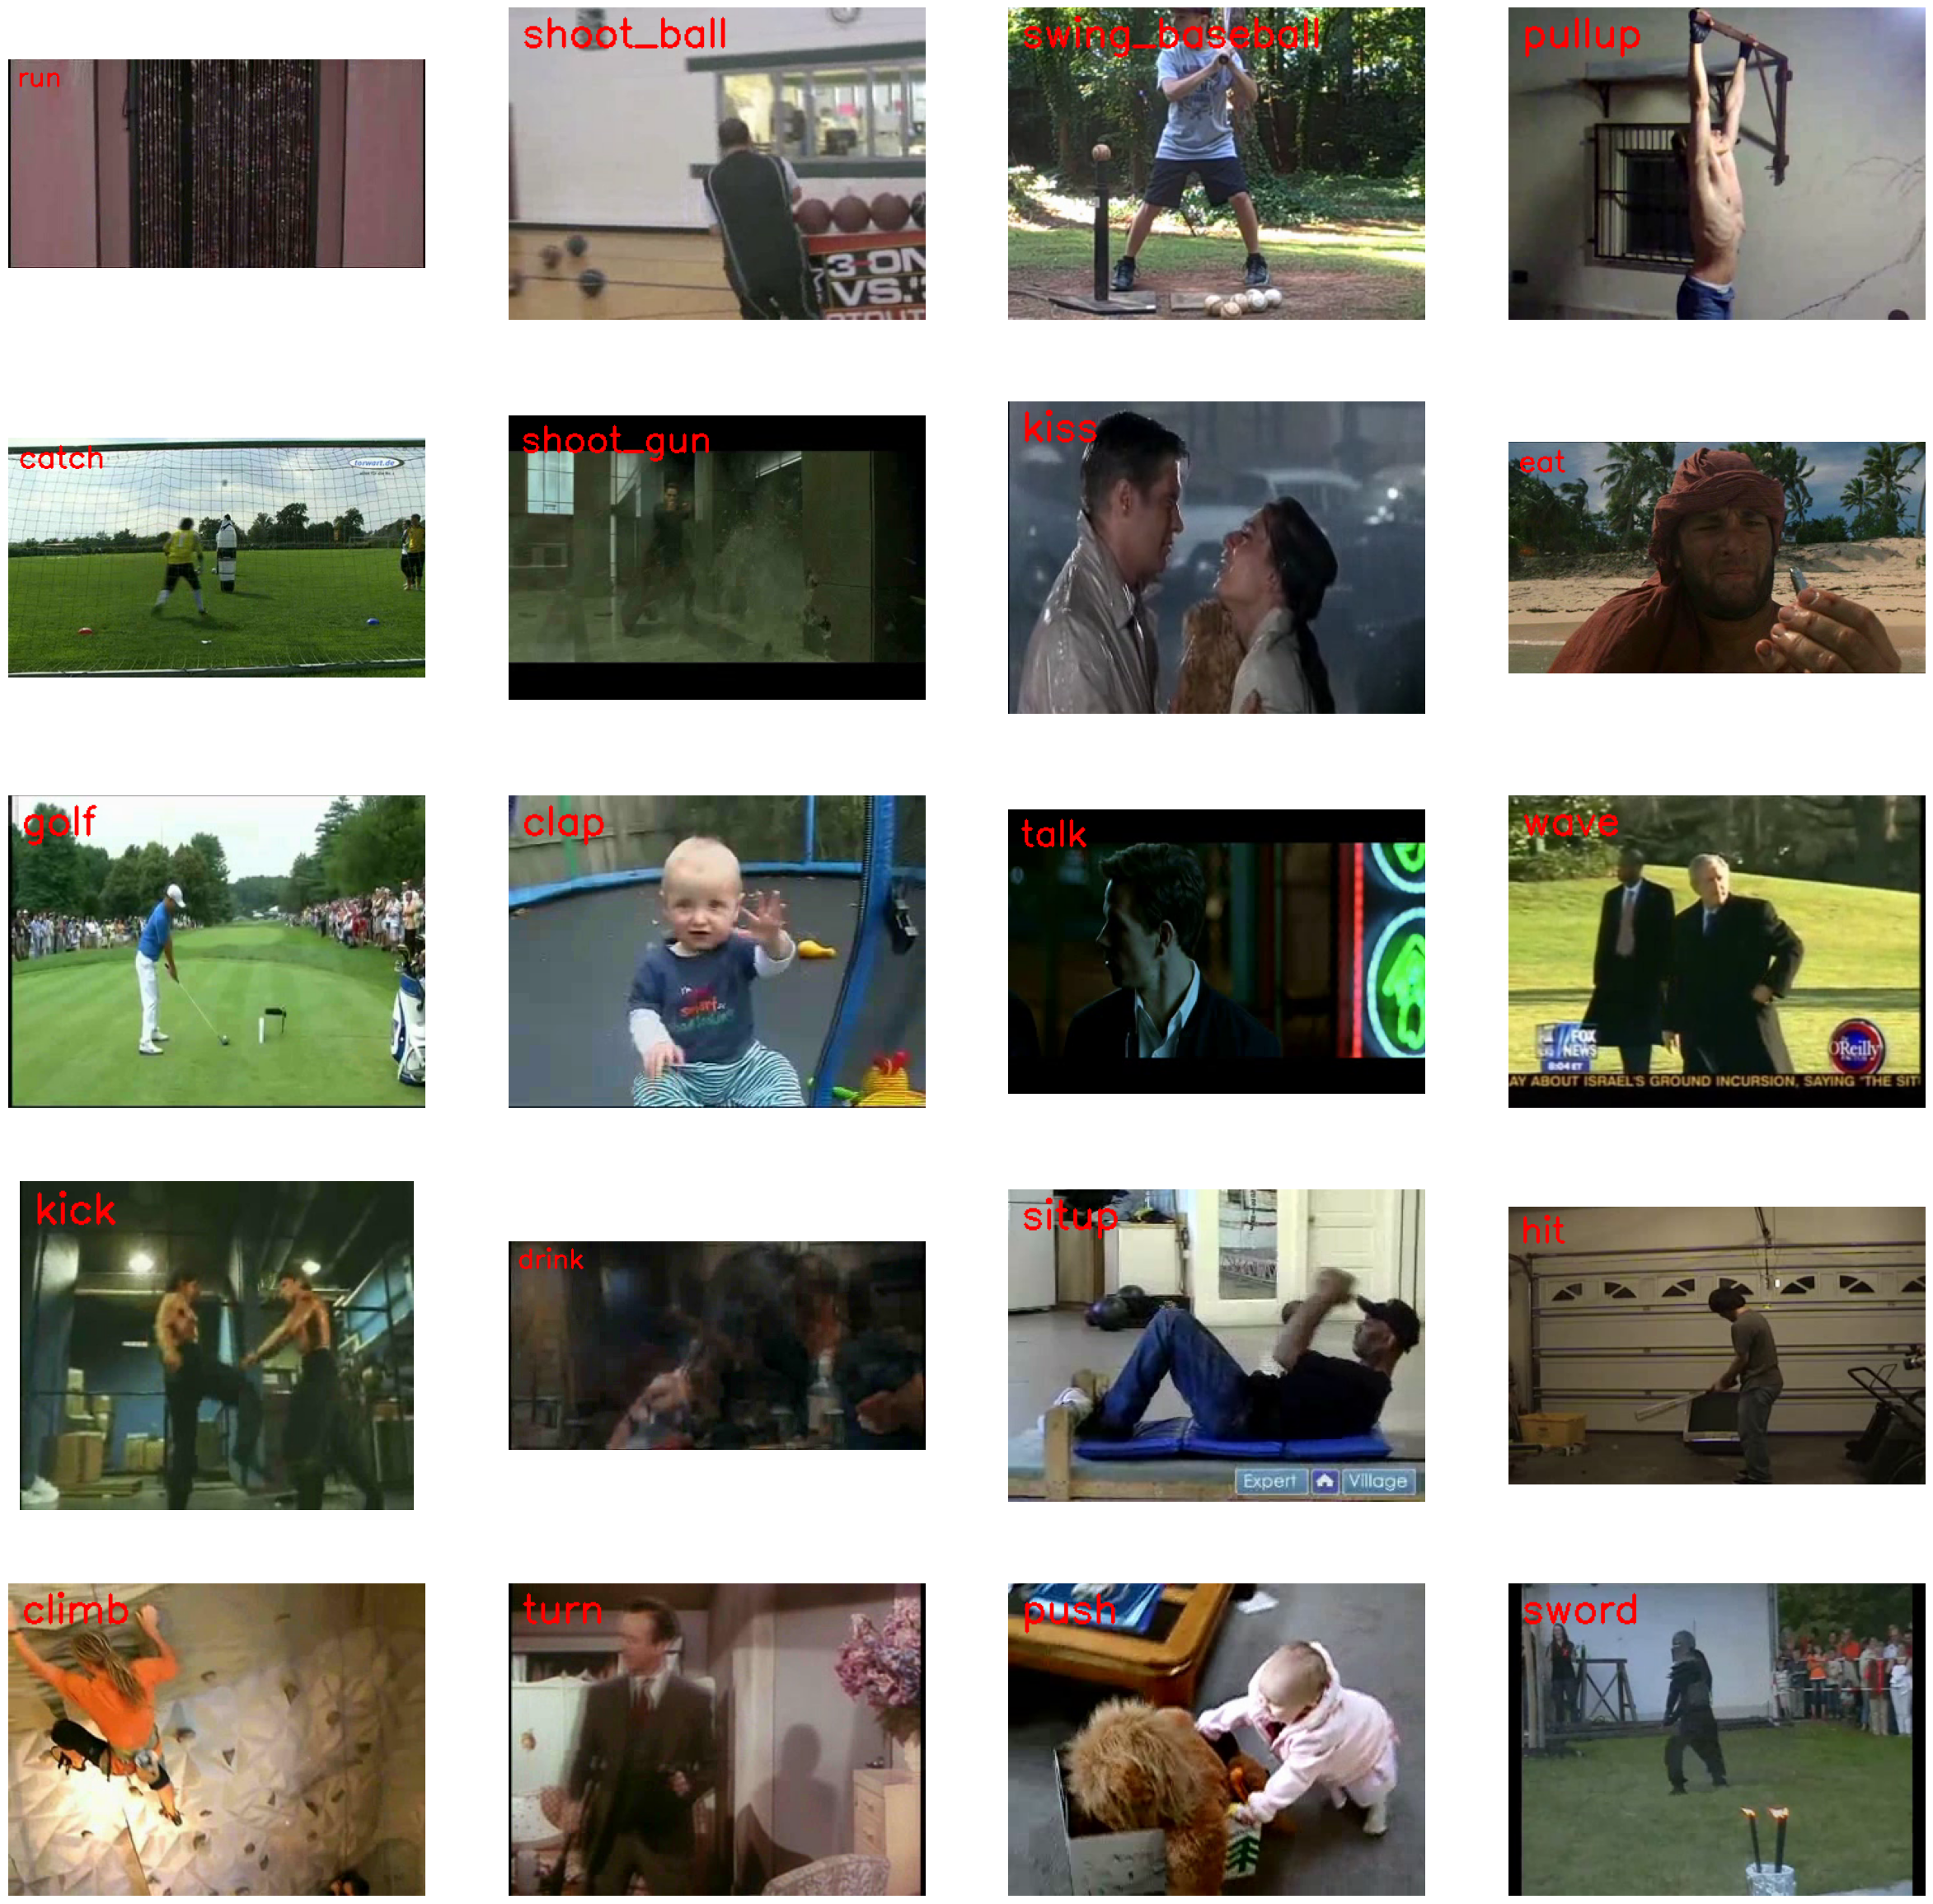

In [2]:
# in order for the code to run properly you need this specific version of the HMDB data set that was uploaded to Kaggle:
# https://www.kaggle.com/datasets/avigoen/hmdb-human-activity-recognition
main_data_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/' 
all_classes_names = os.listdir(main_data_dir)

# Create a Matplotlib figure
fig = plt.figure(figsize = (30, 30))

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{main_data_dir}{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{main_data_dir}{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off') 


In [3]:
image_height, image_width = 128, 128
num_classes = 51
# Function to extract frames from a video
def extract_frames(video_path, skip=9):
    """
    video_path: str
    skip: int
    Returns: A sequence of images. 
    For instance, when skip=9, returns every 10th frame of the video located at the video_path.
    """
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        frames_list.append(normalized_frame)
    frames_list = [frame for i, frame in enumerate(frames_list) if i % (skip+1) == 0]
    video_reader.release()
    return np.array(frames_list)


# Function to load image dataset for selected classes
def create_image_dataset(main_data_dir, classes_list, max_images_per_class):
    """
    Returns a set of randomly selected images from the training set videos with corresponding labels from all video paths provided.
    """
    data_train, labels_train = [], []
    data_test, labels_test = [], []
    with tqdm(total=len(classes_list)) as pbar:
        for class_index, class_name in enumerate(classes_list):
            class_folder = os.path.join(main_data_dir, class_name)
            video_files = os.listdir(class_folder)
        
            count = 0
            for video_file in video_files:
                video_path = os.path.join(class_folder, video_file)
                frames = extract_frames(video_path, skip=16)
                if len(frames) > 0:  # Ensure frames were extracted
                    rand_frame_ids = np.random.choice(len(frames), size=2, replace=False)
                if "training" in video_file:
                    for id in rand_frame_ids:
                        data_train.append(frames[id]) 
                        labels_train.append(class_index)
                        count += 1
                else:
                    for id in rand_frame_ids:
                        data_test.append(frames[id])  # Use the first frame (can use others too)
                        labels_test.append(class_index)
                        count += 1
                if count >= max_images_per_class:
                    break
            pbar.update(1)

    return np.array(data_train), np.array(data_test), np.array(labels_train), np.array(labels_test)


def videos_to_encodings(encoder, video_paths, labels, skip_frames=4, max_frames=20, image_height=128, image_width=128):
    """
    encoder: A keras model that processes the (128,128,3) images to encodings.
    Yields encoded videos and corresponding labels from all video paths provided.
    """
    while True:
        X, y = [], []
        with tqdm(total=len(labels)) as pbar:
            for video_path, label in zip(video_paths, labels):
                frames = extract_frames(video_path, skip=skip_frames)    
                if frames is not None:
                    # Initialize a padded array of zeros
                    padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                    # Copy the frames into the padded array, truncating if necessary
                    num_frames = min(len(frames), max_frames)
                    padded_frames[:num_frames] = frames[:num_frames]
    
                    # encode frames with pretrained image encoder
                    encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                    X.append(np.squeeze(encoded_frames, axis=1))
                    y.append(label)  # Append label as-is or pad if needed for sequences
                    pbar.update(1)
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [4]:
# Prepare paths and labels for training and testing
video_paths_train = [os.path.join(main_data_dir, cls, f) 
                     for cls in all_classes_names 
                     for f in os.listdir(os.path.join(main_data_dir, cls)) 
                     if "training" in f]

labels_train = [all_classes_names.index(cls) 
                for cls in all_classes_names 
                for f in os.listdir(os.path.join(main_data_dir, cls)) 
                if "training" in f]

video_paths_test = [os.path.join(main_data_dir, cls, f) 
                    for cls in all_classes_names 
                    for f in os.listdir(os.path.join(main_data_dir, cls)) 
                    if "testing" in f]

labels_test = [all_classes_names.index(cls) 
               for cls in all_classes_names 
               for f in os.listdir(os.path.join(main_data_dir, cls)) 
               if "testing" in f]

print(f"Total Training Videos: {len(video_paths_train)}, Total Test Videos: {len(video_paths_test)}")

Total Training Videos: 5215, Total Test Videos: 1551


## Image Encoder

In [5]:
# utility functions for training and visualization
def compile_and_train_model(model, optimizer, train, val, epochs: int, callbacks: list, verbose=2):
    """
        model: A keras.Model
        optimizer: which training optimizer to use, e.g., "adam"
        train: training set
        val: validation set
        epochs: how many epochs to train the model for
        callbacks: list of call backs such as early stopping
        
        returns: tuple of model, training history, and final validation set accuracy
    """
    # compile
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # train
    train_hist = model.fit(
        train,
        epochs=epochs,
        validation_data=val,
        callbacks=callbacks,
        verbose=verbose
    )
    return (model, train_hist)

def plot_training_history(train_hist, model_name:str):
    """
    Plots the training graph for accuracy and loss with model_name as suptitle.
    """
    history_frame = pd.DataFrame(train_hist.history)

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plt.suptitle(model_name)
    ax[0].plot(history_frame.index, history_frame['accuracy'], label='train')
    ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='val')
    _ = ax[0].set_xlabel('Epoch')
    _ = ax[0].set_ylabel('Accuracy')
    _ = ax[0].legend(loc='lower right')
    _ = ax[0].set_title("Accuracy Curve")
    
    ax[1].plot(history_frame.index, history_frame['loss'], label='train')
    ax[1].plot(history_frame.index, history_frame['val_loss'], label='val')
    _ = ax[1].set_xlabel('Epoch')
    _ = ax[1].set_ylabel('Loss')
    _ = ax[1].legend(loc='upper right')
    _ = ax[1].set_title("Loss Curve")
    fig.show()

def evaluate_model(model, train_ds, val_ds,test_ds):
    # Evaluate the model
    train_evaluation = model.evaluate(train_ds, verbose=0)
    print(f"Train Loss: {train_evaluation[0]:.3f}, Train Accuracy: {train_evaluation[1]:.3f}")
    val_evaluation = model.evaluate(val_ds, verbose=0)
    print(f"Val Loss: {val_evaluation[0]:.3f}, Val Accuracy: {val_evaluation[1]:.3f}")
    test_evaluation = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_evaluation[0]:.3f}, Test Accuracy: {test_evaluation[1]:.3f}")
    print(f"Averaged Accuracy over all 3 splits: {np.mean([test_evaluation[1], val_evaluation[1], train_evaluation[1]]):.3f}")

In [6]:
# Create the dataset for the Image encoder
max_images_per_class = 200
X_train, X_test, y_train, y_test = create_image_dataset(main_data_dir, all_classes_names, max_images_per_class)
print(f"Dataset size: {y_train.shape[0] + y_test.shape[0]}, Train: {y_train.shape}, Test: {y_test.shape}")

# batch and shuffle train data
train_img_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(y_train.shape[0]).batch(100)
# split test data into training and validation
test_img_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(y_test.shape[0]).batch(100)
test_img_ds, val_img_ds = tf.keras.utils.split_dataset(test_img_ds, left_size=0.5, right_size=0.5)

100%|██████████| 51/51 [04:15<00:00,  5.02s/it]


Dataset size: 10200, Train: (7898,), Test: (2302,)


In [7]:
# Define the VGG16 base model with an explicit input shape
base = tf.keras.applications.VGG16(
    include_top=False,  # Remove the fully connected layers
    weights='imagenet',  # Use pretrained weights
    input_shape=(image_height, image_width, 3)  # Explicitly define the input shape
)

# Freeze the base model layers
base.trainable = False
base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Build and train image encoder 
num_classes = len(all_classes_names)
image_classifier = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

# **Explicitly Build the Model by Passing Sample Input**
# Generate a sample input with the correct shape
sample_input = np.random.random((1, image_height, image_width, 3))  # Batch of 1
image_classifier(sample_input)

image_classifier.summary()

image_classifier, ic_hist = compile_and_train_model(
    image_classifier,
    optimizer="adam",
    train=train_img_ds,
    val=val_img_ds,
    epochs=30,
    callbacks= [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-4, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (1, 4, 4, 512)         │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 8192)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 64)                │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 51)                │         3,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,774,963 (60.18 MB)

 Trainable params: 1,060,275 (4.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30


I0000 00:00:1734869712.977397   20581 service.cc:145] XLA service 0x78bf68005e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734869712.977451   20581 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734869712.977455   20581 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/79 ━━━━━━━━━━━━━━━━━━━━ 27:11 21s/step - accuracy: 0.0300 - loss: 4.1786

I0000 00:00:1734869729.565723   20581 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 59s 483ms/step - accuracy: 0.0329 - loss: 3.9293 - val_accuracy: 0.1199 - val_loss: 3.4384 - learning_rate: 0.0010
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.1118 - loss: 3.4364 - val_accuracy: 0.3050 - val_loss: 2.8155 - learning_rate: 0.0010
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.1960 - loss: 3.0397 - val_accuracy: 0.3545 - val_loss: 2.5564 - learning_rate: 0.0010
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.2519 - loss: 2.7549 - val_accuracy: 0.4605 - val_loss: 2.1430 - learning_rate: 0.0010
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.3232 - loss: 2.4488 - val_accuracy: 0.5039 - val_loss: 1.9895 - learning_rate: 0.0010
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.3748 - loss: 2.2563 - val_accuracy: 0.5291 - val_loss: 1.8144 - learning_rate: 0.0010
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.4017 - loss: 2.1230 - val_

Image Classifier Accuracy across the data set:
Train Loss: 0.801, Train Accuracy: 0.824
Val Loss: 1.498, Val Accuracy: 0.631
Test Loss: 1.514, Test Accuracy: 0.626
Averaged Accuracy over all 3 splits: 0.694


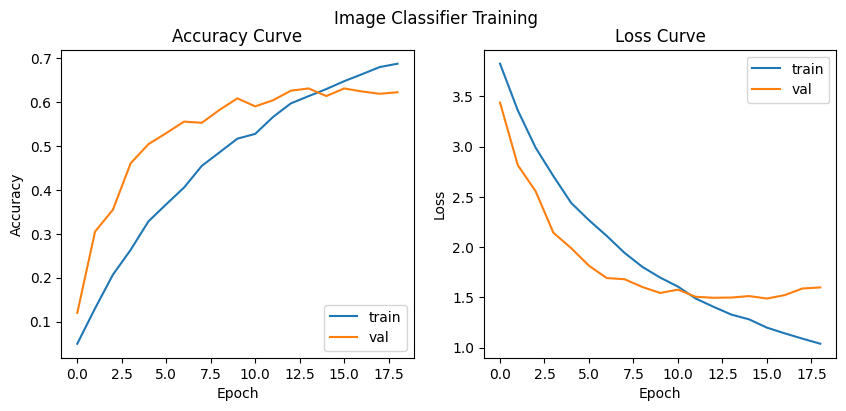

In [9]:
plot_training_history(ic_hist, "Image Classifier Training")
print("Image Classifier Accuracy across the data set:")
evaluate_model(image_classifier, train_img_ds, val_img_ds, test_img_ds)

In [10]:
image_classifier.save("hmdb51_8k_train_vgg16_img_enc.h5")

### Model Comparisons on Video Data

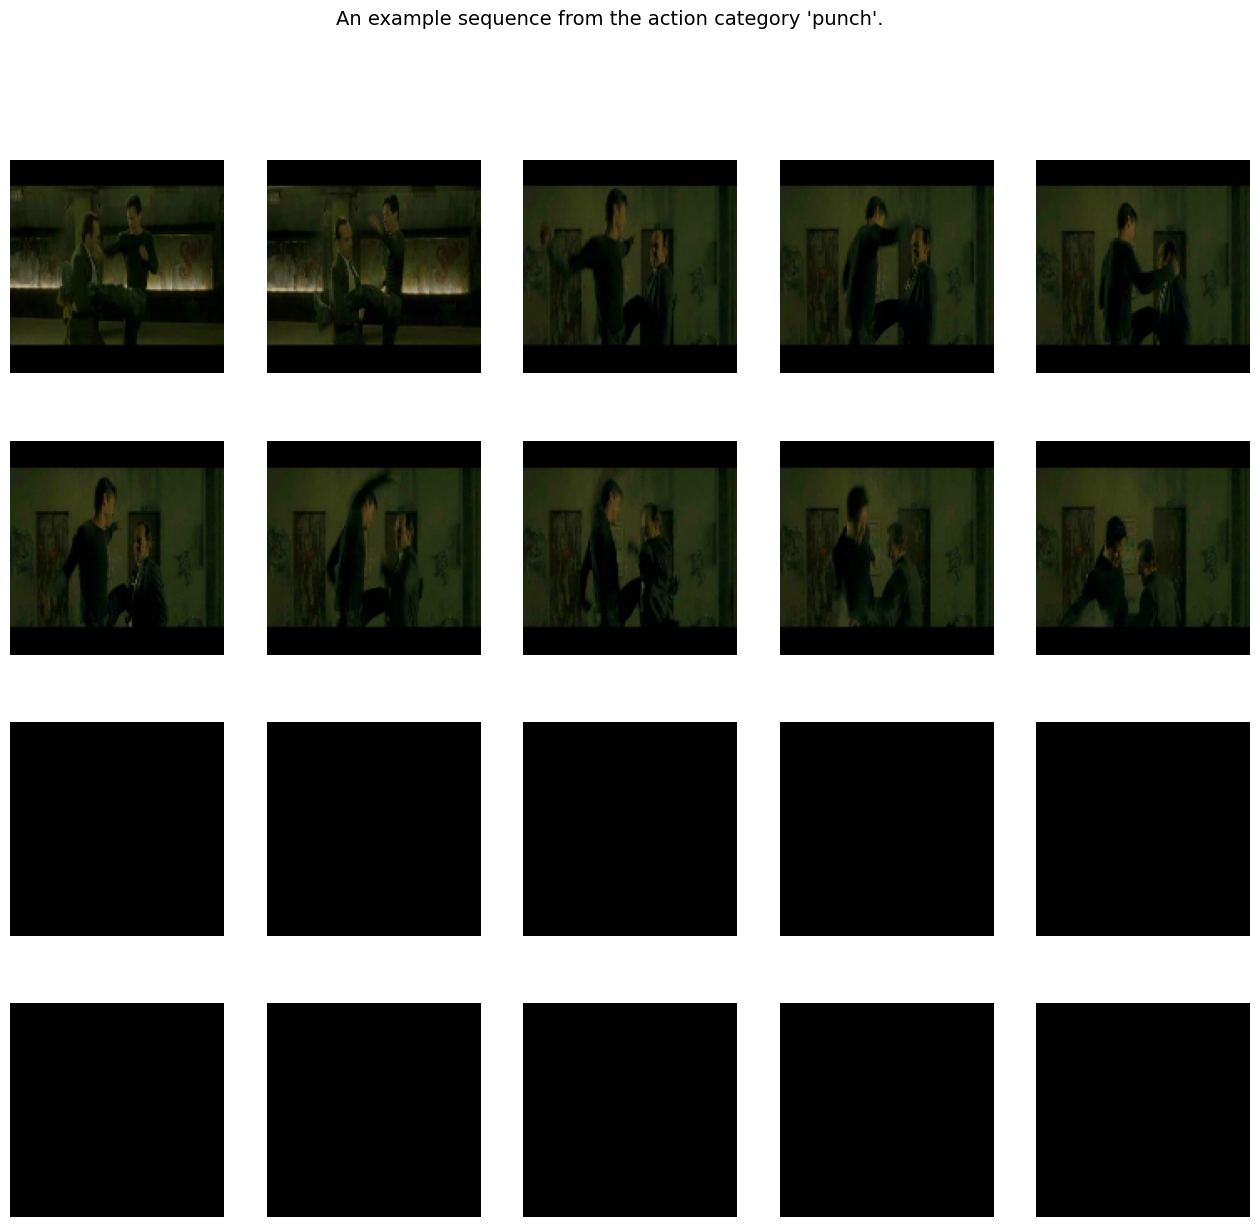

In [11]:
# rerun cell to get another example sequence
id = np.random.randint(5215)
vid_path = video_paths_train[id]
# pad frames
frames = extract_frames(vid_path, skip=5)
max_frames = 20
padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
num_frames = min(len(frames), max_frames)
padded_frames[:num_frames] = frames[:num_frames]

fig, ax = plt.subplots(4,5, figsize=(16,14))
_ = plt.suptitle(f"An example sequence from the action category '{all_classes_names[labels_train[id]]}'.", fontsize=14)
for i, frame in enumerate(padded_frames):
    frame
    row = i // 5
    col = i % 5
    ax[row,col].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[row,col].set_axis_off()

In [12]:
#pretrained_image_classifier = keras.models.load_model("/kaggle/input/vgg16_fine_tuned_img_enc/keras/hmdb51_8k_train/1/img_enc.h5")
img_enc = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),  # Ensure input shape matches your image size
    *image_classifier.layers[:-2]  # Exclude the final output layer
])
img_enc.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,648 (60.16 MB)

 Trainable params: 1,056,960 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# encoded video data set generators
frames_per_video = 20
encode_train_set = videos_to_encodings(img_enc, video_paths_train, labels_train, max_frames=frames_per_video)
encode_test_set = videos_to_encodings(img_enc, video_paths_test, labels_test, max_frames=frames_per_video)
# load training data from raw videos to encoder outputs
X_train, y_train = next(encode_train_set)
print(f"Total training set loaded, Shape:{X_train.shape}")

# convert training data to tf.Dataset and split into training and validation:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(y_train.shape[0]).batch(50)
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size=0.8, right_size=0.2)

# load training data from raw videos to encoder outputs
X_test, y_test = next(encode_test_set)
print(f"Test set loaded, Shape:{X_test.shape}")
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(y_train.shape[0]).batch(50)

100%|██████████| 5215/5215 [38:32<00:00,  2.26it/s]


Total training set loaded, Shape:(5215, 20, 64)


100%|██████████| 1551/1551 [11:23<00:00,  2.27it/s]

Test set loaded, Shape:(1551, 20, 64)


### Base-Model Performance (Image-Classifier only)

We can simply reuse the encoder generator which will give us predictions for each image of the training set.

In [17]:
predictions_img_classifier = videos_to_encodings(image_classifier, video_paths_test, labels_test)
y_pred, _ = next(predictions_img_classifier)

100%|██████████| 1551/1551 [11:58<00:00,  2.16it/s]


This will yield 20 predictions per testing sample since the image encoder was trained on frames (images) rather than sequences of frames, we will have to come up with a way to combine the predictions of the image encoder for each individual frame into a prediction for the whole sequence of frames. The simplest way to do this is to take the largest probability assigned to each frame as the prediction for each frame and then take the most frequent prediction (mode) for the whole sequence.

In [18]:
pred_per_sequence = []
for sequence in y_pred:
    pred_classes, pred_counts = np.unique(np.argmax(sequence, axis=1), return_counts=True)
    most_frequent_prediction = pred_classes[np.argmax(pred_counts)]
    pred_per_sequence.append(most_frequent_prediction)

baseline_accuracy = np.mean(y_test == np.array(pred_per_sequence))
print(f"Base-line Accuracy on test set: {baseline_accuracy:3f}")

Base-line Accuracy on test set: 0.533849


### RCNN (CNN: VGG-16-image-encoder, RNN-type: LSTM)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (1, 51)                │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,419 (540.70 KB)

 Trainable params: 138,419 (540.70 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1122 - loss: 3.6583 - val_accuracy: 0.3854 - val_loss: 2.3078 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3428 - loss: 2.3265 - val_accuracy: 0.5417 - val_loss: 1.6730 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4668 - loss: 1.8471 - val_accuracy: 0.5906 - val_loss: 1.5214 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5323 - loss: 1.6665 - val_accuracy: 0.5964 - val_loss: 1.4684 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5696 - loss: 1.4993 - val_accuracy: 0.6146 - val_loss: 1.3705 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5986 - loss: 1.4221 - val_accuracy: 0.6309 - val_loss: 1.3242 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6185 - loss: 1.2985 - va

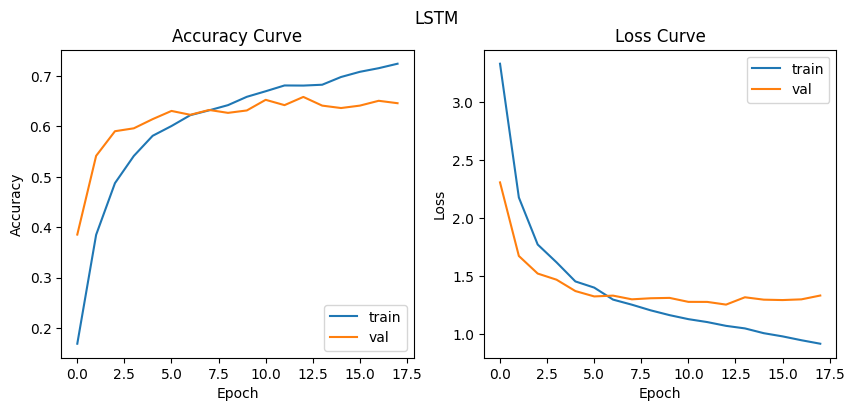

In [29]:
img_enc_lstm = keras.Sequential([
    layers.LSTM(128, return_sequences=False, recurrent_dropout=0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_lstm(np.expand_dims(X_train[0], axis=0))

print(img_enc_lstm.summary())

img_enc_lstm, lstm_hist = compile_and_train_model(
    img_enc_lstm, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=30, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ],
    verbose=1
)
print("LSTM's Accuracy across the data set:")
evaluate_model(img_enc_lstm, train_ds, val_ds, test_ds)
plot_training_history(lstm_hist, "LSTM")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (1, 128)               │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (1, 51)                │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,259 (1.58 MB)

 Trainable params: 138,419 (540.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,840 (1.06 MB)

None
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.0796 - loss: 3.9734 - val_accuracy: 0.3337 - val_loss: 2.7796 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3262 - loss: 2.7301 - val_accuracy: 0.5446 - val_loss: 1.9732 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4607 - loss: 2.1272 - val_accuracy: 0.5992 - val_loss: 1.7326 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5406 - loss: 1.8795 - val_accuracy: 0.6107 - val_loss: 1.6614 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5836 - loss: 1.7283 - val_accuracy: 0.6309 - val_loss: 1.6007 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6155 - loss: 1.6166 - val_accuracy: 0.6290 - val_loss: 1.5886 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6273 - loss: 1.5437 - va

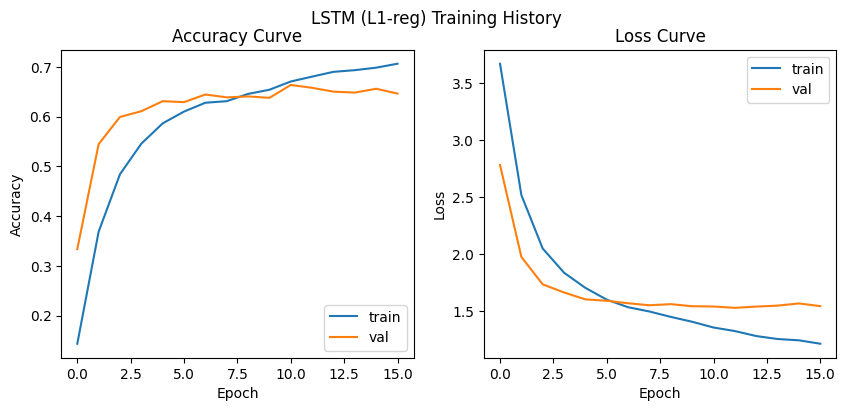

In [30]:
# LSTM with L1 regularisation to prevent overfitting
img_enc_lstm_l1 = keras.Sequential([
    layers.LSTM(128, return_sequences=False, recurrent_dropout=0.2),
    layers.Dense(128, activation="relu", 
        kernel_regularizer=keras.regularizers.L1(1e-4),
        bias_regularizer=keras.regularizers.L2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu", 
        kernel_regularizer=keras.regularizers.L1(1e-4),
        bias_regularizer=keras.regularizers.L2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_lstm_l1(np.expand_dims(X_train[0], axis=0))

print(img_enc_lstm_l1.summary())

img_enc_lstm_l1, lstm_hist_l1 = compile_and_train_model(
    img_enc_lstm_l1, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=30, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

print("LSTM (L1) Accuracy across the data set:")
evaluate_model(img_enc_lstm_l1, train_ds, val_ds, test_ds)
plot_training_history(lstm_hist_l1, "LSTM (L1-reg) Training History")

### RCNN with Bi-LSTM

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (1, 256)               │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (1, 128)               │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (1, 51)                │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,619 (990.70 KB)

 Trainable params: 253,619 (990.70 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0990 - loss: 3.6511 - val_accuracy: 0.4267 - val_loss: 2.1806 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3519 - loss: 2.3785 - val_accuracy: 0.5580 - val_loss: 1.5668 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4877 - loss: 1.8392 - val_accuracy: 0.6165 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5195 - loss: 1.6450 - val_accuracy: 0.6299 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5672 - loss: 1.5341 - val_accuracy: 0.6395 - val_loss: 1.3030 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5860 - loss: 1.4395 - val_accuracy: 0.6433 - val_loss: 1.2840 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6047 - loss: 1.3954 - va

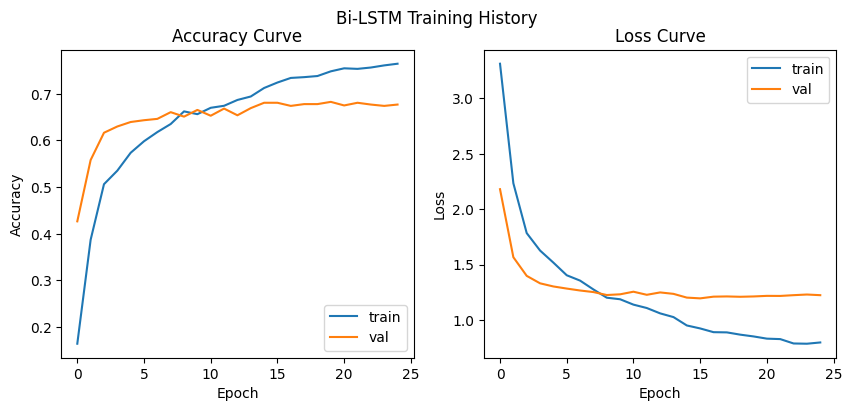

In [31]:
img_enc_bilstm = keras.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=False, recurrent_dropout=0.2)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_bilstm(np.expand_dims(X_train[0], axis=0))
print(img_enc_bilstm.summary())

img_enc_bilstm, bi_hist = compile_and_train_model(
    img_enc_bilstm, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=30, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)],
    verbose=1
    )
print("Bi-LSTM's Accuracy across the data set:")
evaluate_model(img_enc_bilstm, train_ds, val_ds, test_ds)
plot_training_history(bi_hist, "Bi-LSTM Training History")

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_11                │ (1, 256)               │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (1, 128)               │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (1, 128)               │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (1, 51)                │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,619 (990.70 KB)

 Trainable params: 253,619 (990.70 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1035 - loss: 3.9965 - val_accuracy: 0.4516 - val_loss: 2.5858 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3506 - loss: 2.7294 - val_accuracy: 0.5992 - val_loss: 1.8197 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4887 - loss: 2.1579 - val_accuracy: 0.6481 - val_loss: 1.6781 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5570 - loss: 1.8845 - val_accuracy: 0.6405 - val_loss: 1.6243 - learning_rate: 0.0010
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5728 - loss: 1.8129 - val_accuracy: 0.6395 - val_loss: 1.6002 - learning_rate: 0.0010
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5881 - loss: 1.7315 - val_accuracy: 0.6414 - val_loss: 1.5636 - learning_rate: 0.0010
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6218 - loss: 1.6313 - va

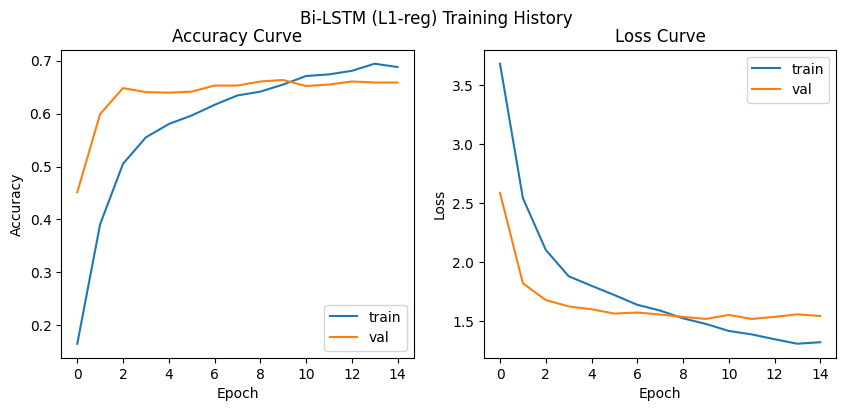

In [42]:
# Bi-LSTM with L1 regularisation to prevent overfitting
img_enc_bilstm_l1 = keras.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=False, recurrent_dropout=0.2)),
    layers.Dense(128, activation="relu", 
        kernel_regularizer=keras.regularizers.L1(1e-4),
        bias_regularizer=keras.regularizers.L2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu", 
        kernel_regularizer=keras.regularizers.L1(1e-4),
        bias_regularizer=keras.regularizers.L2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_bilstm_l1(np.expand_dims(X_train[0], axis=0))
print(img_enc_bilstm_l1.summary())

img_enc_bilstm_l1, bi_hist_l1 = compile_and_train_model(
    img_enc_bilstm_l1, 
    optimizer='adam', 
    train = train_ds,
    val = val_ds,
    epochs=30, 
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)],
    verbose=1
    )

print("Bi-LSTM (L1) Accuracy across the data set:")
evaluate_model(img_enc_bilstm_l1, train_ds, val_ds, test_ds)
plot_training_history(bi_hist_l1, "Bi-LSTM (L1-reg) Training History")

### Training Comparison

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


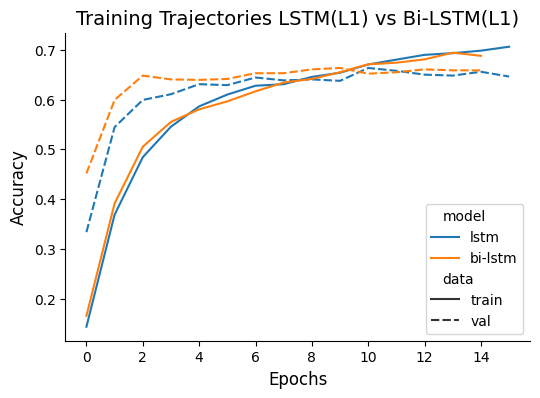

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'hist' and 'bi_hist' are Keras history objects
epochs_lstm = range(len(lstm_hist_l1.history["accuracy"]))
epochs_bilstm = range(len(bi_hist_l1.history["accuracy"]))

# Prepare the data for plotting
df = pd.DataFrame({
    "Epochs": list(epochs_lstm) * 2 + list(epochs_bilstm) * 2,
    "Accuracy": lstm_hist_l1.history["accuracy"][:40] + lstm_hist_l1.history["val_accuracy"][:40] +
                bi_hist_l1.history["accuracy"] + bi_hist_l1.history["val_accuracy"],
    "model": (["lstm"] * len(epochs_lstm) + ["lstm"] * len(epochs_lstm) +
                   ["bi-lstm"] * len(epochs_bilstm) + ["bi-lstm"] * len(epochs_bilstm)),
    "data": (["train"] * len(epochs_lstm) + ["val"] * len(epochs_lstm) +
                   ["train"] * len(epochs_bilstm) + ["val"] * len(epochs_bilstm)),
})

# Create the plot
plt.figure(figsize=(6,4))
sns.lineplot(data=df, x="Epochs", y="Accuracy", hue="model", style="data", markers=False)

# Customize plot
plt.title("Training Trajectories LSTM(L1) vs Bi-LSTM(L1)", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
#plt.legend(title="Model and Curve Type", fontsize=12)
sns.despine()

# Show the plot
plt.show()

**Table 1.** Model Comparison Results.
| Model | Accuracy Test Set | Average Acccuracy (3 splits)|
|---|---|---|
|  Baseline | 57.1% | - |
|  LSTM | 68% | 69.9% |
|  LSTM (L1 reg.) | 67.8% | 69.4% |
|  Bi-LSTM | **68.2%** | **72.9%** |
|  Bi-LSTM (L1 reg.) | 67.5% | 69.3% |

### Error Analysis

F1-Scores and Confusion Matrix of the best fitting model (LSTM(L1))
                precision    recall  f1-score   support

     kick_ball       0.75      0.84      0.79        25
         catch       0.91      0.97      0.94        30
    shoot_ball       0.88      0.95      0.92        40
  climb_stairs       0.86      0.80      0.83        30
         punch       0.54      0.79      0.64        28
         stand       0.06      0.20      0.10        10
         smoke       0.79      0.70      0.75        27
          clap       0.72      0.68      0.70        38
    somersault       0.53      0.51      0.52        35
         drink       0.48      0.41      0.44        27
        pushup       0.94      0.97      0.96        35
          push       0.78      0.78      0.78        32
          talk       0.57      0.57      0.57        23
       fencing       0.79      0.87      0.83        30
          golf       0.68      0.87      0.76        15
   shake_hands       0.65      0.80

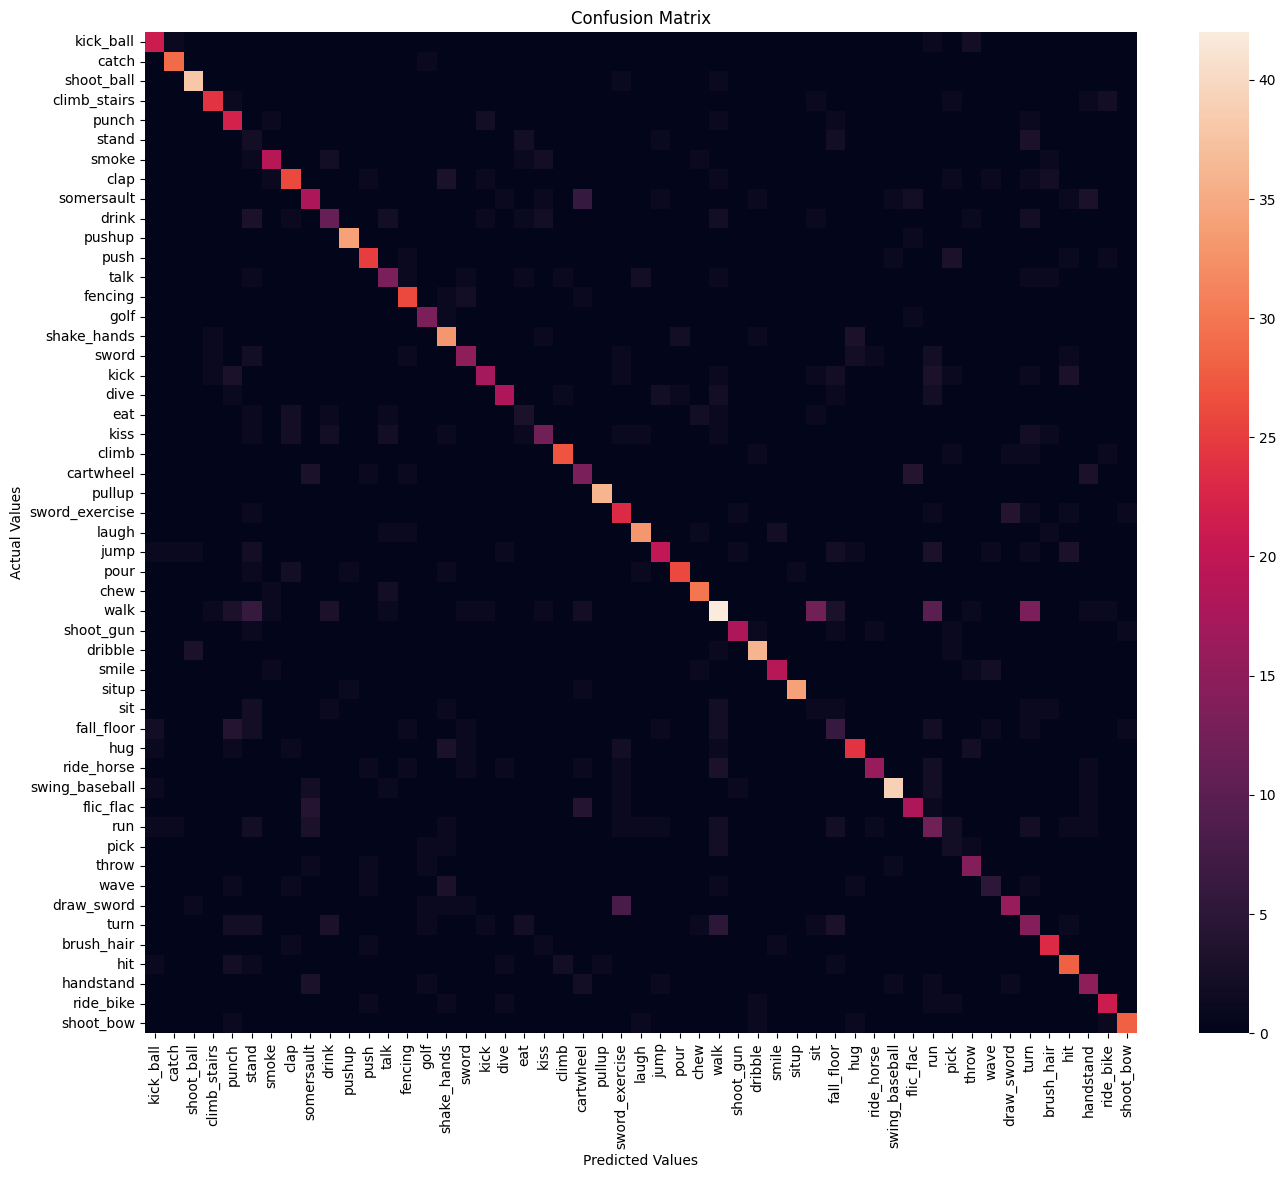

In [44]:
y_true = y_test
y_pred = np.argmax(img_enc_bilstm(X_test), axis=1)

print("F1-Scores and Confusion Matrix of the best fitting model (LSTM(L1))")
print(classification_report(y_true, y_pred, target_names=all_classes_names))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm,
                     index = all_classes_names, 
                     columns = all_classes_names)
_ = plt.figure(figsize=(16,13))
_ = sns.heatmap(cm_df)
_ = plt.title('Confusion Matrix')
_ = plt.ylabel('Actual Values')
_ = plt.xlabel('Predicted Values')